<a href="https://colab.research.google.com/github/Mo-kw/Image-Colorization-Using-U-Net-Architecture/blob/main/Image_Colorization_Using_U_Net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("theblackmamba31/landscape-image-colorization")

print("Path to dataset files:", path)

100%|██████████| 192M/192M [00:09<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/theblackmamba31/landscape-image-colorization/versions/4


In [2]:
pwd


'/content'

In [3]:
mv /root/.cache/kagglehub/datasets/theblackmamba31/landscape-image-colorization/versions/4 /content

In [15]:
# Import required libraries
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import amp
from skimage import color


In [16]:
# Dataset class for paired grayscale and color images
class GrayColorDataset(Dataset):
    def __init__(self, gray_dir, color_dir, img_size=256):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.img_size = img_size
        self.filenames = os.listdir(gray_dir)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        gray_path = os.path.join(self.gray_dir, filename)
        color_path = os.path.join(self.color_dir, filename)

        gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(color_path)
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

        gray_img = cv2.resize(gray_img, (self.img_size, self.img_size))
        color_img = cv2.resize(color_img, (self.img_size, self.img_size))

        lab = color.rgb2lab(color_img).astype("float32")
        L = gray_img.astype("float32") / 255.0 * 100
        ab = lab[:, :, 1:] / 128.0

        L_tensor = torch.tensor(L).unsqueeze(0) / 100.0
        ab_tensor = torch.tensor(ab).permute(2, 0, 1)

        return L_tensor, ab_tensor


In [17]:
# U-Net architecture with encoder (downsampling) and decoder (upsampling) parts connected by skip connections.
class UNetColor(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(64, 2, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Decoder
        d3 = self.up3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.final(d1)
        return torch.tanh(out)


In [18]:
# Initialize dataset, model, optimizer, and loss function with train/val/test split
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

full_dataset = GrayColorDataset(
    "/content/4/landscape Images/gray",
    "/content/4/landscape Images/color"
)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = UNetColor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [21]:
# Training loop
scaler = amp.GradScaler()

for epoch in range(20):
    model.train()
    total_loss = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for L, ab in loop:
        L, ab = L.to(device), ab.to(device)

        optimizer.zero_grad()

        with amp.autocast(device_type='cuda'):
            pred_ab = model(L)
            loss = criterion(pred_ab, ab)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {epoch_time:.2f}s")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for L, ab in val_loader:
            L, ab = L.to(device), ab.to(device)
            with amp.autocast(device_type='cuda'):
                pred_ab = model(L)
                loss = criterion(pred_ab, ab)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"           - Val   Loss: {avg_val_loss:.4f}")


Epoch 1 - Train Loss: 0.0114 - Time: 197.85s
           - Val   Loss: 0.0099


Epoch 2 - Train Loss: 0.0105 - Time: 192.10s
           - Val   Loss: 0.0099


Epoch 3 - Train Loss: 0.0101 - Time: 191.14s
           - Val   Loss: 0.0095


Epoch 4 - Train Loss: 0.0098 - Time: 191.23s
           - Val   Loss: 0.0092


Epoch 5 - Train Loss: 0.0095 - Time: 191.72s
           - Val   Loss: 0.0098


Epoch 6 - Train Loss: 0.0095 - Time: 192.55s
           - Val   Loss: 0.0090


Epoch 7 - Train Loss: 0.0094 - Time: 193.01s
           - Val   Loss: 0.0093


Epoch 8 - Train Loss: 0.0093 - Time: 191.45s
           - Val   Loss: 0.0090


Epoch 9 - Train Loss: 0.0092 - Time: 191.50s
           - Val   Loss: 0.0089


Epoch 10 - Train Loss: 0.0091 - Time: 192.48s
           - Val   Loss: 0.0086


Epoch 11 - Train Loss: 0.0090 - Time: 192.08s
           - Val   Loss: 0.0085


Epoch 12 - Train Loss: 0.0090 - Time: 193.26s
           - Val   Loss: 0.0090


Epoch 13 - Train Loss: 0.0089 - Time: 193.96s
           - Val   Loss: 0.0086


Epoch 14 - Train Loss: 0.0090 - Time: 192.08s
           - Val   Loss: 0.0085


Epoch 15 - Train Loss: 0.0089 - Time: 193.26s
           - Val   Loss: 0.0086


Epoch 16 - Train Loss: 0.0088 - Time: 194.92s
           - Val   Loss: 0.0084


Epoch 17 - Train Loss: 0.0088 - Time: 192.20s
           - Val   Loss: 0.0084


Epoch 18 - Train Loss: 0.0088 - Time: 191.39s
           - Val   Loss: 0.0085


Epoch 19 - Train Loss: 0.0088 - Time: 191.52s
           - Val   Loss: 0.0087


Epoch 20 - Train Loss: 0.0088 - Time: 191.85s
           - Val   Loss: 0.0088


In [22]:
# Convert predicted Lab back to RGB for visualization
def lab_to_rgb(L, ab):
    L = L.squeeze().cpu().numpy() * 100
    ab = ab.squeeze().cpu().numpy() * 128
    lab = np.zeros((L.shape[0], L.shape[1], 3))
    lab[:, :, 0] = L
    lab[:, :, 1:] = ab.transpose(1, 2, 0)
    rgb = color.lab2rgb(lab)
    return rgb


In [24]:
# Save the trained model weights to a file
torch.save(model.state_dict(), "colorization_unet.pth")


In [25]:
# Load saved model weights
model = UNetColor().to(device)
model.load_state_dict(torch.load("colorization_unet.pth", map_location=device))
model.eval()


UNetColor(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

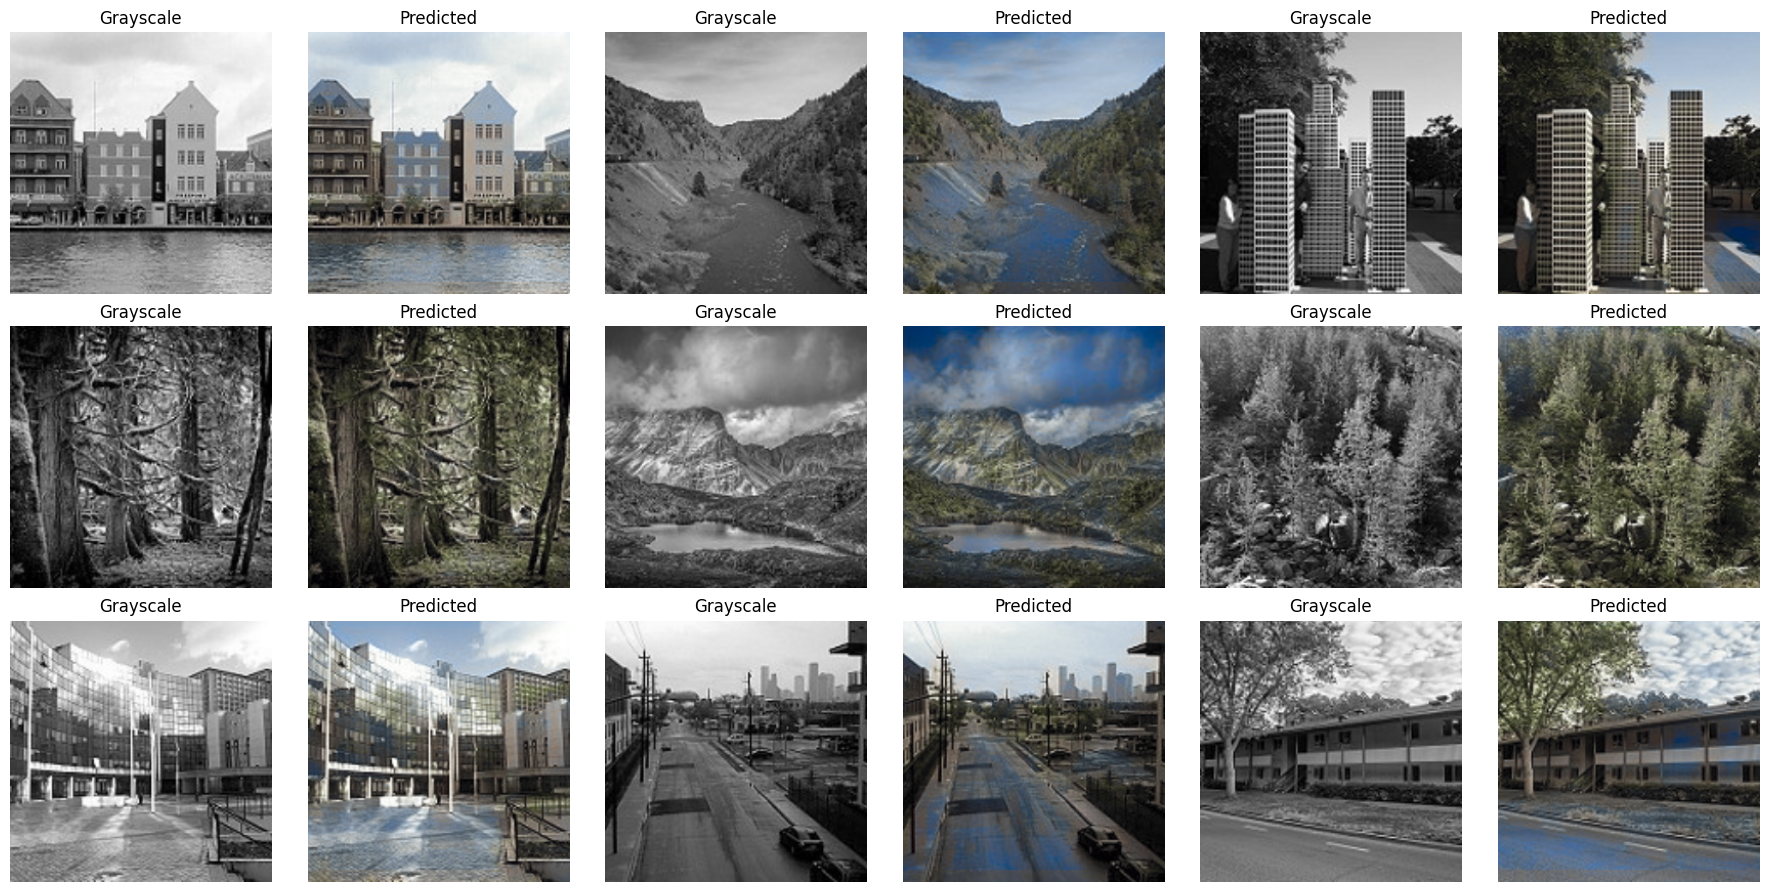

In [31]:
import matplotlib.pyplot as plt
import random

# Collect all test samples
all_samples = []
with torch.no_grad():
    for L, ab in test_loader:
        L = L.to(device)
        pred_ab = model(L)
        for i in range(L.size(0)):
            gray = L[i].cpu()
            pred = pred_ab[i].cpu()
            pred_rgb = lab_to_rgb(gray, pred)
            all_samples.append((gray.squeeze().numpy(), pred_rgb))

# Randomly pick 9 samples
selected_samples = random.sample(all_samples, 9)

# Plot: 3 rows x 6 columns (grayscale + prediction side-by-side per image)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 9))

for idx, (gray, pred) in enumerate(selected_samples):
    row = idx // 3
    col = (idx % 3) * 2  # 0, 2, 4

    axs[row, col].imshow(gray, cmap='gray')
    axs[row, col].set_title("Grayscale")
    axs[row, col + 1].imshow(pred)
    axs[row, col + 1].set_title("Predicted")

    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()
